# Object Detection using OpenCV

This Code Template is for Object Detection in python using the OpenCV library. Object Detection is A computer vision technique that deals with detecting objects in an image or video. This technique draws a boundary or a bounding box around the target object and may also include their target label. It has many real-life applications like, image retrieval and video surveillance.

### **Required Packages**

In [ ]:
!pip install opencv-python

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Initialization

Path of the image to be loaded

In [2]:
#image path variable
img_path = ''

### Image Fetching

OpenCV-Python is a library of Python bindings designed to solve computer vision problems. 

We use the the "**cv2.imread()**" method to load an image from the specified file path.

In [3]:
def plot_image(path):
    image = cv2.imread(path) 
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,12))
    plt.imshow(img) 
    plt.axis("off")
    plt.show()
    
    return img

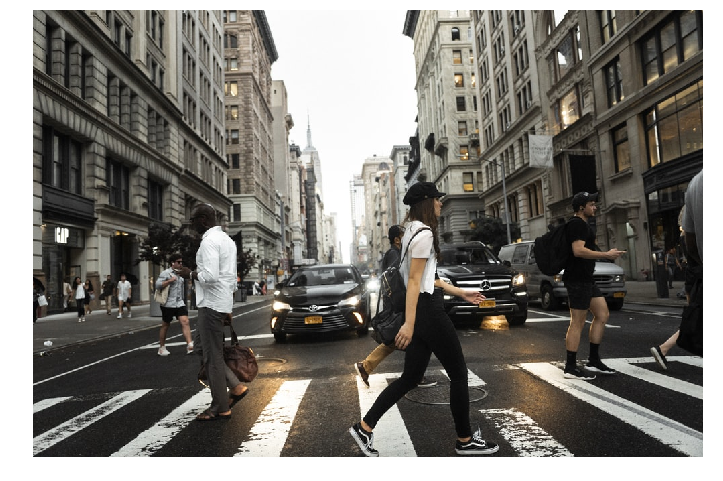

In [4]:
img = plot_image(img_path)

### Image Labels

Here, the COCO dataset is used for image labeling since the model YOLO is trained on it. This dataset is popular for Object Detection and constitutes 80 labels including oven, toaster, bench, car, etc.

The file is downloadable at [coco.names](https://opencv-tutorial.readthedocs.io/en/latest/_downloads/a9fb13cbea0745f3d11da9017d1b8467/coco.names)

In [ ]:
classFile = '' # Path to labels

In [5]:
classes = []
with open(classFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

### Model 
OpenCV uses the function <Code>cv2.dnn.readNet()</Code> to load a pre-trained weights and network configuration of supported format and build object detection model. This function automatically detects an origin framework of trained model and calls an appropriate function such readNetFromCaffe, readNetFromTensorflow, readNetFromTorch or readNetFromDarknet. 

#### Model Tuning Parameters
1. **model**: const String &  	
>Binary file contains trained weights. 

2. **config**: const String &
>Text file contains network configuration

3. **framework**: const String & 
>Explicit framework name tag to determine a format.

More  details at the [API](https://docs.opencv.org/4.5.1/d6/d0f/group__dnn.html)

#### YOLO
In this tutorial, the model used is YOLO — You Only Look Once. It is an extremely fast multi object detection algorithm which uses convolutional neural network (CNN) to detect and identify objects.

>**config_path**: [YOLO Configuration File](https://opencv-tutorial.readthedocs.io/en/latest/_downloads/10e685aad953495a95c17bfecd1649e5/yolov3.cfg)

>**weights_path**: [YOLO Weights](https://pjreddie.com/media/files/yolov3.weights)

Paths to configuration and weight files

In [6]:
config_path = '' # configuration path
weights_path = '' # weights path

In [7]:
net = cv2.dnn.readNet(config_path, weights_path)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

# determine the output layer
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

### BLOB
OpenCv object detection models take input images as BLOBs. A BLOB is a binary large object (BLOB) is a collection of binary data stored as a single entity.

<Code>cv2.dnn.blobFromImage()</Code> 
creates 4-dimensional blob from image. Optionally resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels.

#### Parameters

1. **image**: InputArray 	
>input image (with 1-, 3- or 4-channels).

2. **size**: const Size &
>spatial size for output image


3. **scalefactor**:	double 
>multiplier for image values.

4. **swapRB**: bool 
>flag which indicates that swap first and last channels in 3-channel image is necessary.

5. **crop**: bool 	
>flag which indicates whether image will be cropped after resize or not


More details at the [API](https://docs.opencv.org/4.5.1/d6/d0f/group__dnn.html)

In [8]:
blob = cv2.dnn.blobFromImage(image = img, 
                             scalefactor = 1/255.0, 
                             size = (256, 256), 
                             swapRB=True, 
                             crop=False)

net.setInput(blob)
outputs = net.forward(output_layers)

### Inference
Following code section [[Reference](https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html)] draws bounding box and a corresponding confidence score around an object. Confidence score is the probability that a bounding box contains an object. 

<Code>cv.dnn.NMSBoxes</Code> performs non maximum suppression given boxes and corresponding scores.

#### Parameters
1. **bboxes**: const std::vector< Rect > &
>a set of bounding boxes to apply NMS.
2. **scores**: 	const std::vector< float > & 
>a set of corresponding confidences.
3. **score_threshold**: const float 
>a threshold used to filter boxes by score.
4. **nms_threshold**: 	const float 
>a threshold used in non maximum suppression.

More details at the [API](https://docs.opencv.org/4.5.1/d6/d0f/group__dnn.html)

In [9]:
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

# random colors for bounding box
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8') #np.full((len(classes), 3), 255, dtype='uint8')

# Bounding Box and Confidence Score
for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

# Non Maximum Suppression 
indices = cv2.dnn.NMSBoxes(bboxes = boxes, 
                           scores = confidences, 
                           score_threshold = 0.4, 
                           nms_threshold  = 0.3)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)

### Plot Image with Bounding Boxes

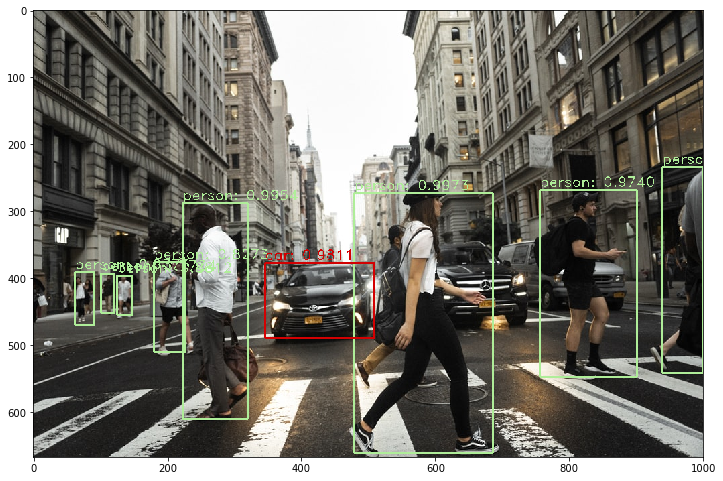

In [10]:
plt.figure(figsize = (12,12))
plt.imshow(img)
plt.show()

#### Creator: Viraj Jayant, Github: [Profile](https://github.com/Viraj-Jayant)